In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

sns.set()

In [28]:
def create_accuracy_dict(expDir, keepSet):
    """Creates the dictionary with all experiments

    Arguments:
        expDir {string} -- folder containing all experiment folder
        keepSet {int} -- 0 excludes sets with removed samples
                         1 only sets with removed samples
                         2 includes all
        
    Returns:
        dict -- accucary set over all runs
    """
    modes = set([])
    dset = ['Train', 'Val', 'Test']
    # loop all directories
    for filename in os.listdir(expDir):
        # filter the experiments
        if keepSet == 0:
            if "_removed" in filename:
                continue
        elif keepSet == 1:
            if not "_removed" in filename and not "mislabel" in filename:
                continue
        modes.add(filename)
    
    accuracyDict = {}
    # loop all setups
    for m in modes:
        if 'mislabel' in m:
            perc = ''
            corr = '0'
        accuracyDict[m] = {}
        for filename in os.listdir(os.path.join(expDir, m)):
            # get setup and create dict entry
            if not 'mislabel' in m:
                perc, corr, run = filename.split('-')
            if not perc in accuracyDict[m]:
                accuracyDict[m][perc] = {}
            if not corr in accuracyDict[m][perc]:
                accuracyDict[m][perc][corr] = {}
            # get evaluation files
            if 'mislabel' in m:
                eva_file = os.path.join(expDir, m, 'evaluation.txt')
            else:
                eva_file = os.path.join(expDir, m, filename, 'evaluation.txt')
            with open(eva_file, "r") as f:
                accs = []
                for line in f:
                    accs.append(float(line.split('Accuracy: ')[-1]))
            for i, s in enumerate(dset):
            # loop all datasets and fill dictionary
                if not dset[i] in accuracyDict[m][perc][corr]:
                    accuracyDict[m][perc][corr][s] = {}
                    accuracyDict[m][perc][corr][s]['acc_avg'] = accs[i]
                    accuracyDict[m][perc][corr][s]['acc_min'] = accs[i]
                    accuracyDict[m][perc][corr][s]['acc_max'] = accs[i]
                else:
                    accuracyDict[m][perc][corr][s]['acc_avg'] = np.average([accs[i], accuracyDict[m][perc][corr][s]['acc_avg']])
                    accuracyDict[m][perc][corr][s]['acc_min'] = np.min([accs[i], accuracyDict[m][perc][corr][s]['acc_min']])
                    accuracyDict[m][perc][corr][s]['acc_max'] = np.max([accs[i], accuracyDict[m][perc][corr][s]['acc_max']])
    return accuracyDict

def create_acc_plot(accuracyDict, selectSet, selectQuality, save):
    """Creates the plot with all experiments

    Arguments:
        accuarcyFict {dict} -- contains the filtered accuacies to plot
        selectSet {list} -- datasets to plot (Train, Val, Test)
        selectQuality {list} -- dataset quality (e.g. 10)
        save {bool} -- boolean to save the plot
    """
    fig = plt.figure(figsize=(10,4))
    c = 0
    for m in sorted(list(accuracyDict.keys())):
        for perc in sorted(list(accuracyDict[m].keys())):
            for corr in sorted(list(accuracyDict[m][perc].keys())):
                for s in sorted(list(accuracyDict[m][perc][corr].keys())):
                    if not any(sS in s for sS in selectSet):
                        continue
                    if not any(sQ in perc for sQ in selectQuality) and not any(sQ in m for sQ in selectQuality):
                        continue
                    x = c
                    y = accuracyDict[m][perc][corr][s]['acc_avg']
                    yerr_min = accuracyDict[m][perc][corr][s]['acc_avg'] - accuracyDict[m][perc][corr][s]['acc_min']
                    yerr_max = accuracyDict[m][perc][corr][s]['acc_max'] - accuracyDict[m][perc][corr][s]['acc_avg']
                    yerr = [[yerr_min], [yerr_max]]
                    c += 1
                    if 'mislabel' in m:
                        setup = m.replace('mislabel', 'mislabel')
                    else:
                        setup = m + '-' + perc
                    if 'removed' in setup:
                        plt.errorbar(x, y, yerr=yerr, fmt='-x', solid_capstyle='projecting', capsize=5, label=setup)
                    else:
                        plt.errorbar(x, y, yerr=yerr, fmt='-o', solid_capstyle='projecting', capsize=5, label=setup)
                    
    plt.ylabel('Test Accuracy')
    plt.xlabel('Experiment')
    lgd = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
            
    plt.tight_layout(h_pad=2.0)
    path = '../plots/' + expname + '_accuracies.png'
    if save:
        if not os.path.exists('../plots/'):
            os.makedirs('../plots/')
        fig.savefig(path, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    else:
        plt.show()

Adjust 'expname', 'selectedSets' and 'selectedQualities' to filter the accuracies shown in the plot. In addition you can set 'filterExps' to 0 to remove the experiments that cleaned the data by removing samples or to 1 to only show the experiments that cleaned the data by removing samples. Setting it to 2 keeps all experiments.

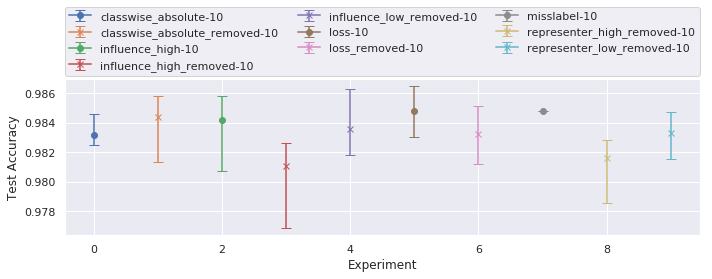

In [44]:
expname = "anomaly_new"
selectedSets = ['Test']
selectedQualities = ['10']
filerExps = 2

model_dir = os.path.join("../models/", expname)
print('Experiment directory: %s' % model_dir)
accuracyDict = create_accuracy_dict(model_dir, filterExps)
create_acc_plot(accuracyDict, selectedSets, selectedQualities, save=False)